In [1]:
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import vector
import numpy as np
vector.register_awkward()

import boost_histogram as bh
import numba
import mplhep
import sklearn
import sklearn.metrics
import matplotlib
import sys

mplhep.set_style(mplhep.styles.CMS)

/tmp/ipykernel_2471433/61174878.py:16: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [2]:
sys.path += ["../../mlpf/plotting//"]
from plot_utils import cms_label, sample_label

In [3]:
@numba.njit
def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_particles(eta1, eta2, phi1, phi2, deltaR_cut):
    nev = len(eta1)
    ptcl_inds_1_ev = []
    ptcl_inds_2_ev = []
    best_drs_ev = []
    for iev in range(nev):
        ptcl_inds_1 = []
        ptcl_inds_2 = []
        best_drs = []

        # loop over the first collection
        pfs_used = np.zeros(len(eta2[iev]))
        for ij1 in range(len(eta1[iev])):
            # compute deltaR from this jet to all jets in the other collection
            drs = 999*np.ones(len(eta2[iev]), dtype=np.float64)

            # loop over the second collection
            for ij2 in range(len(eta2[iev])):
                if pfs_used[ij2]==1:
                    continue
                _eta1 = eta1[iev][ij1]
                _eta2 = eta2[iev][ij2]
                _phi1 = phi1[iev][ij1]
                _phi2 = phi2[iev][ij2]

                dr = deltar(_eta1, _phi1, _eta2, _phi2)
                drs[ij2] = dr

            if len(drs) > 0:
                # find closest match to this particle
                min_idx_dr = np.argmin(drs)

                # has to be closer than the deltaR_cut
                if drs[min_idx_dr] < deltaR_cut:
                    ptcl_inds_1.append(ij1)
                    ptcl_inds_2.append(min_idx_dr)
                    best_drs.append(drs[min_idx_dr])
                    pfs_used[min_idx_dr] = 1
                
        ptcl_inds_1_ev.append(ptcl_inds_1)
        ptcl_inds_2_ev.append(ptcl_inds_2)
        best_drs_ev.append(best_drs)
    return ptcl_inds_1_ev, ptcl_inds_2_ev, best_drs_ev

def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values
    
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1

def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

In [4]:
data_pfs = []
data_mlpfs = []
for ifile in range(1,7):
    print(ifile)
    ev_pf = uproot.open("/local/joosep/mlpf/results/cms/CMSSW_14_1_0_74d149_btvnano/TTbar_noPU_pf/step3_NANO_btv_{}.root".format(ifile)).get("Events")
    ev_mlpf = uproot.open("/local/joosep/mlpf/results/cms/CMSSW_14_1_0_74d149_btvnano/TTbar_noPU_mlpf/step3_NANO_btv_{}.root".format(ifile)).get("Events")
    data_pf = ev_pf.arrays([
        "GenCands_pt", "GenCands_eta", "GenCands_phi", "GenCands_mass", "GenCands_pdgId", "GenCands_charge",
        "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass", "PFCands_pdgId",
        "Jet_pt", "Jet_eta", "Jet_phi",
    ])
    data_pfs.append(data_pf)

    data_mlpf = ev_mlpf.arrays([
        "GenCands_pt", "GenCands_eta", "GenCands_phi", "GenCands_mass", "GenCands_pdgId", "GenCands_charge",
        "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass", "PFCands_pdgId",
        "Jet_pt", "Jet_eta", "Jet_phi",
    ])
    data_mlpfs.append(data_mlpf)

1
2
3
4
5
6


In [5]:
data_pf = ak.concatenate(data_pfs)
data_mlpf = ak.concatenate(data_mlpfs)

In [6]:
def remap_pid(data):
    pid = np.abs(np.asarray(ak.flatten(data["GenCands_pdgId"])))
    pa = ak.flatten(np.abs(data["GenCands_pdgId"]))
    pc = ak.flatten(np.abs(data["GenCands_charge"]))
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenCands_pid"] = ak.unflatten(pid, ak.count(data["GenCands_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

remap_pid(data_pf)
remap_pid(data_mlpf)

Text(1, 0, 'Particle $p_T$ [GeV]')

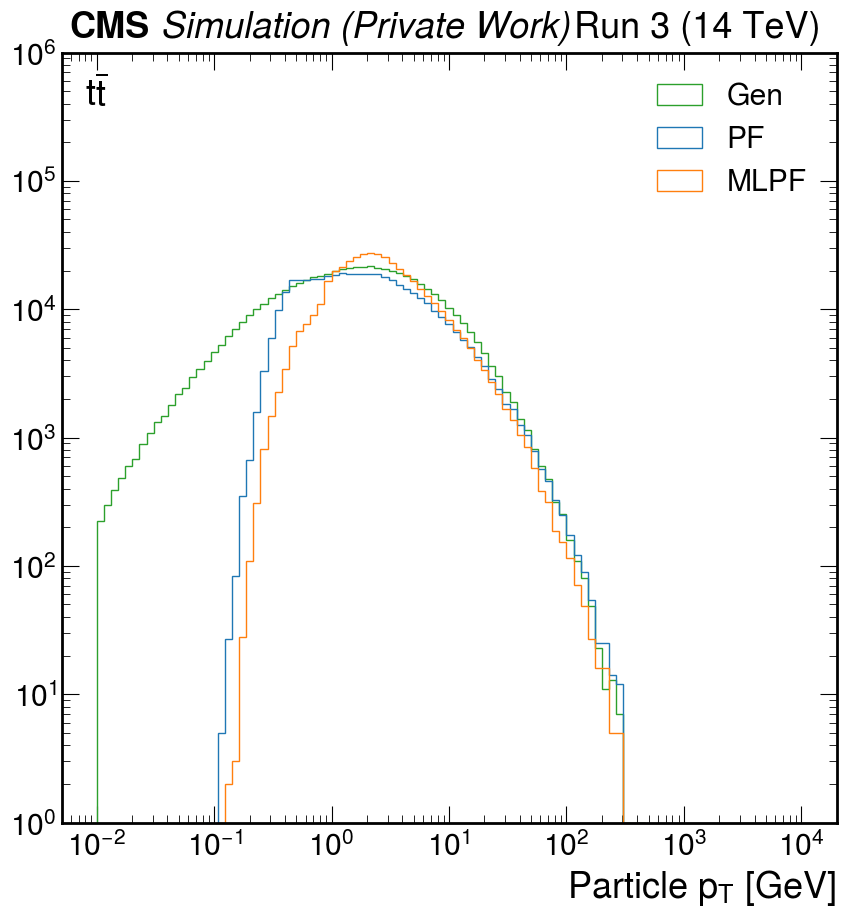

In [7]:
fig = plt.figure()
ax = plt.axes()
b=np.logspace(-2,4,100)
plt.hist(ak.flatten(data_pf["GenCands_pt"]), bins=b, histtype="step", color="tab:green", label="Gen")
plt.hist(ak.flatten(data_pf["PFCands_pt"]), bins=b, histtype="step", color="tab:blue", label="PF")
plt.hist(ak.flatten(data_mlpf["PFCands_pt"]), bins=b, histtype="step", color="tab:orange", label="MLPF")
plt.xscale("log")
plt.yscale("log")
plt.legend()
cms_label(ax)
sample_label(ax, "cms_pf_ttbar_nopu")
plt.ylim(1, 1e6)
plt.xlabel("Particle $p_T$ [GeV]")

Text(1, 0, 'Particle $\\eta$')

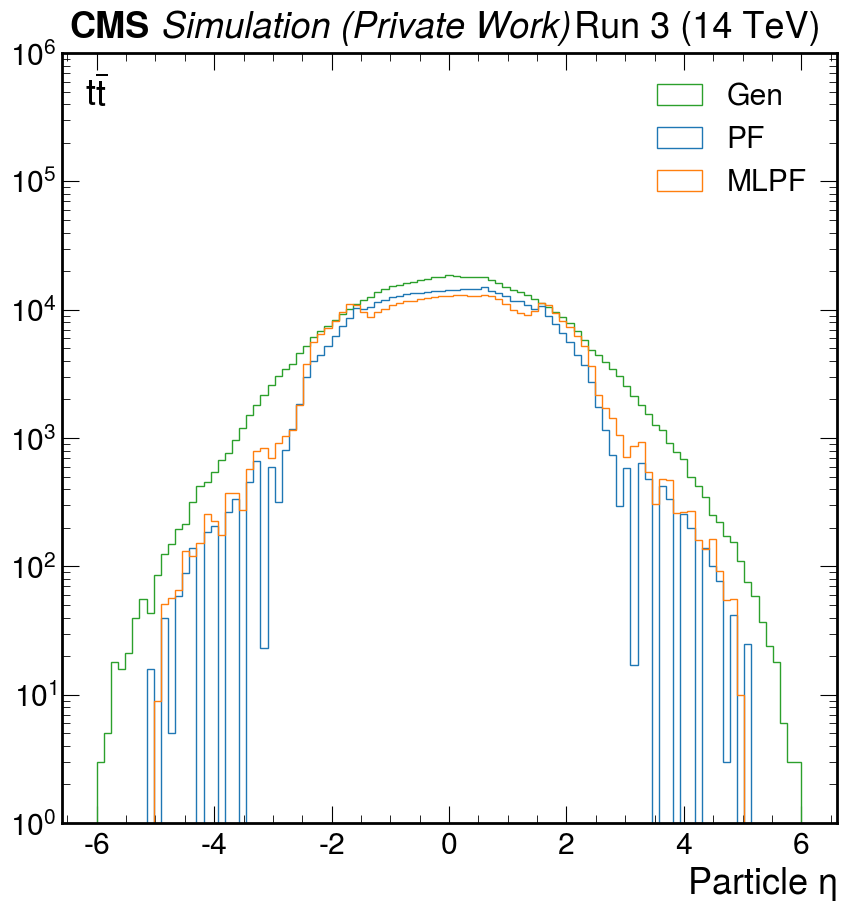

In [8]:
fig = plt.figure()
ax = plt.axes()
b=np.linspace(-6,6,100)
plt.hist(ak.flatten(data_pf["GenCands_eta"]), bins=b, histtype="step", color="tab:green", label="Gen")
plt.hist(ak.flatten(data_pf["PFCands_eta"]), bins=b, histtype="step", color="tab:blue", label="PF")
plt.hist(ak.flatten(data_mlpf["PFCands_eta"]), bins=b, histtype="step", color="tab:orange", label="MLPF")
plt.yscale("log")
plt.legend()
cms_label(ax)
sample_label(ax, "cms_pf_ttbar_nopu")
plt.ylim(1, 1e6)
plt.xlabel("Particle $\eta$")

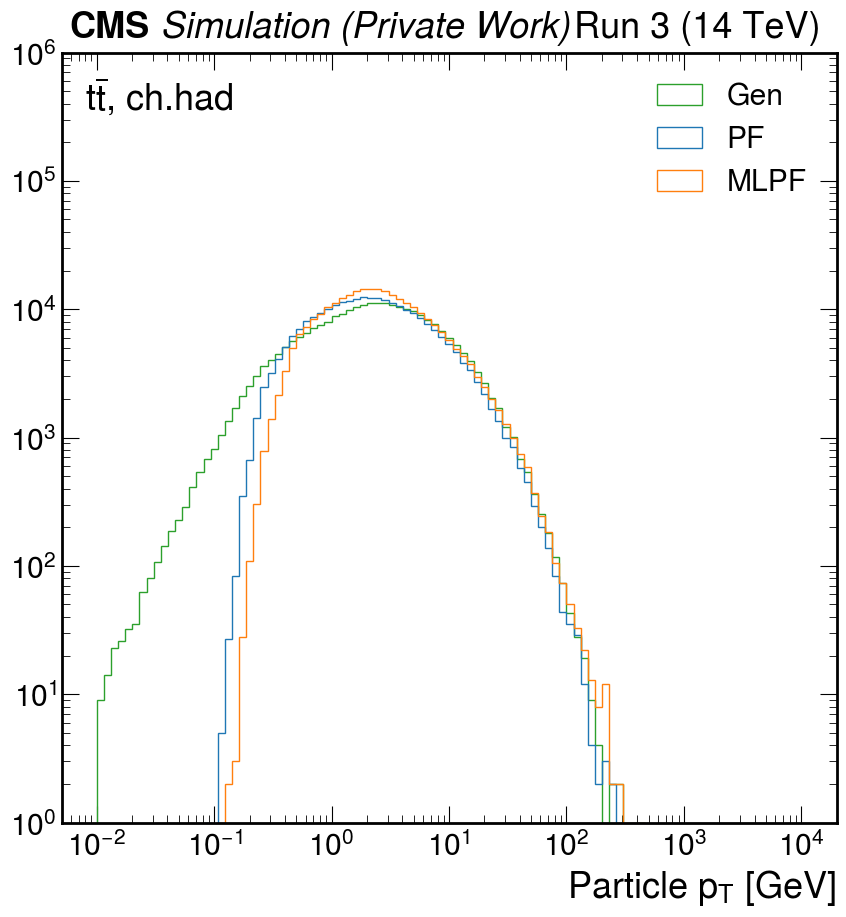

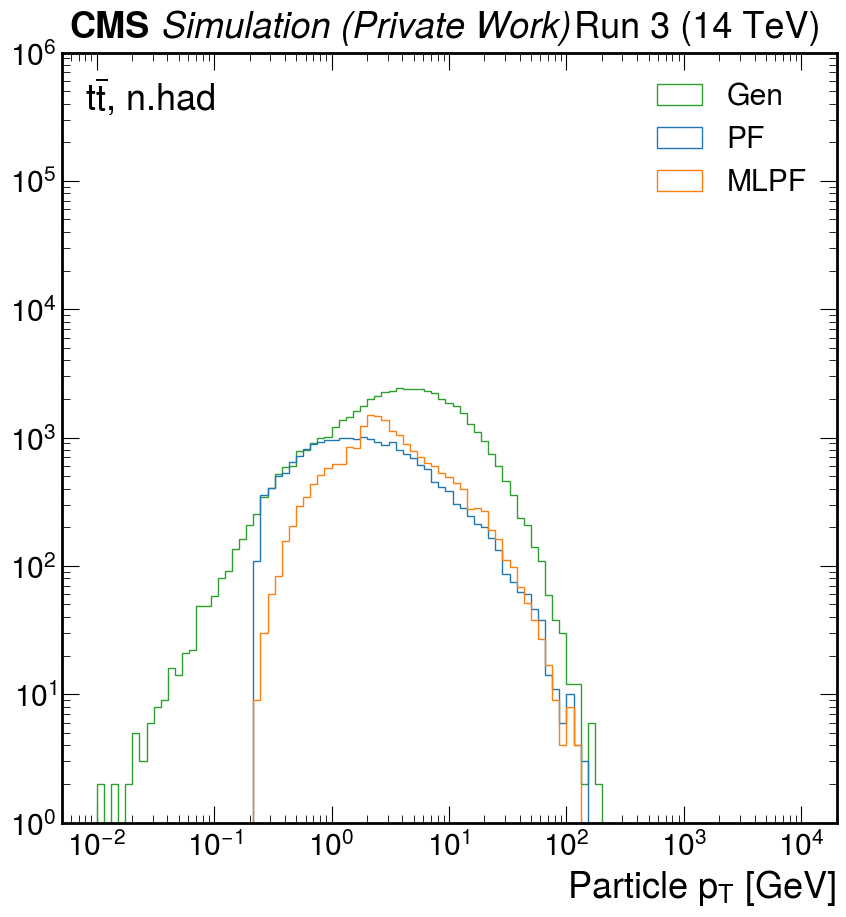

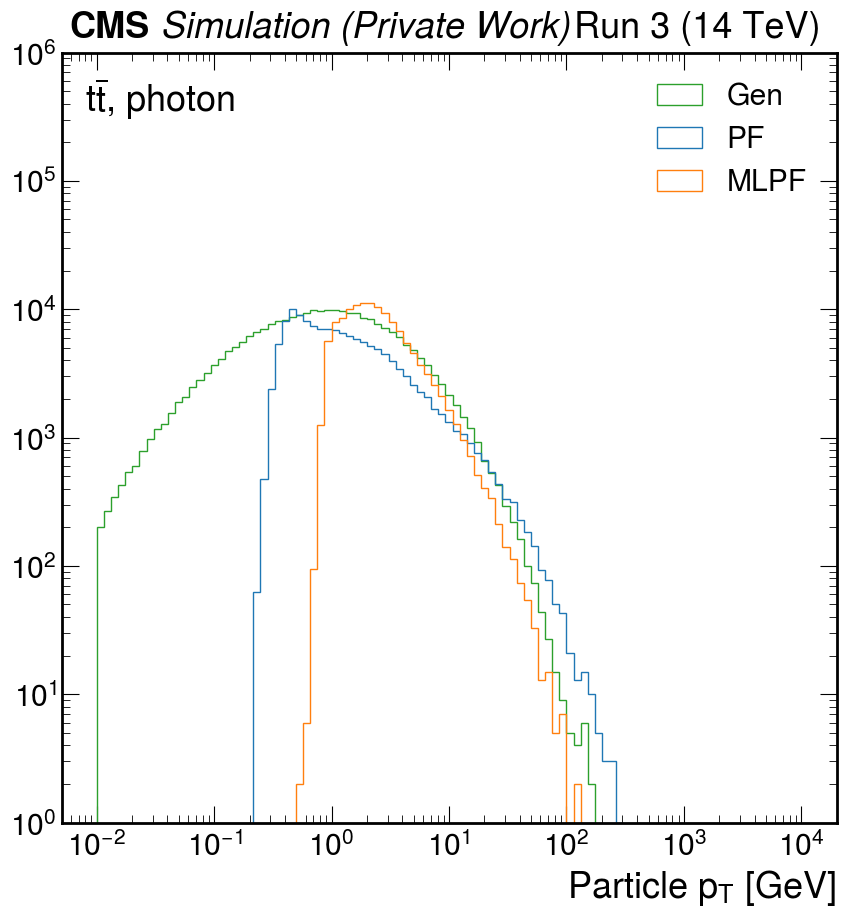

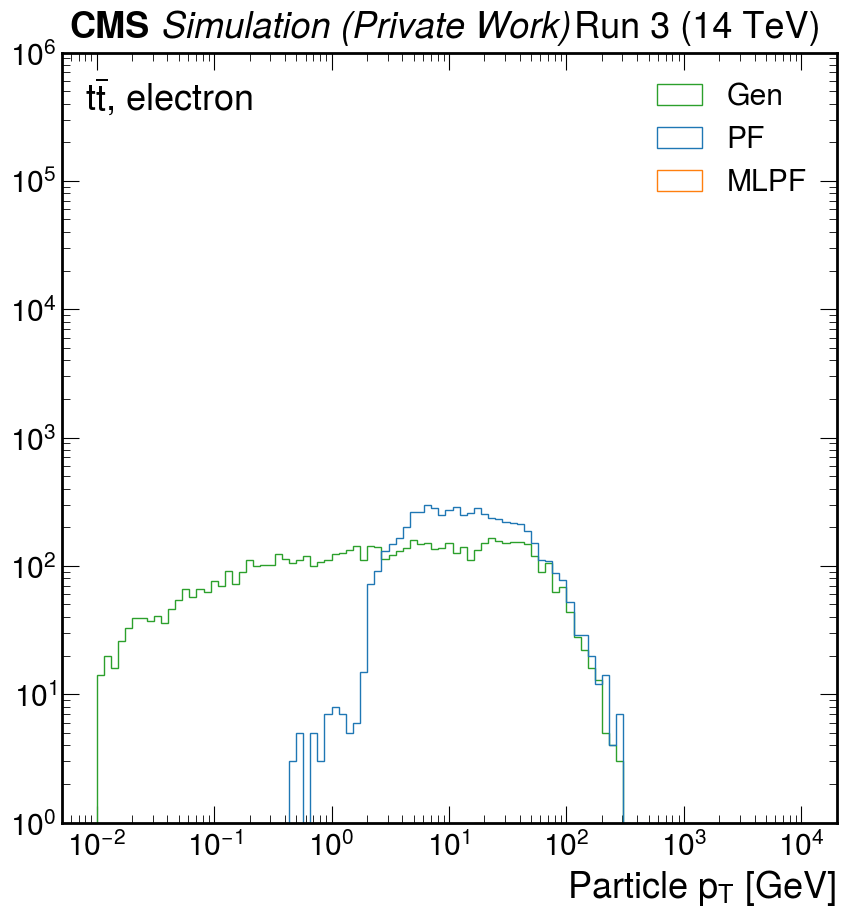

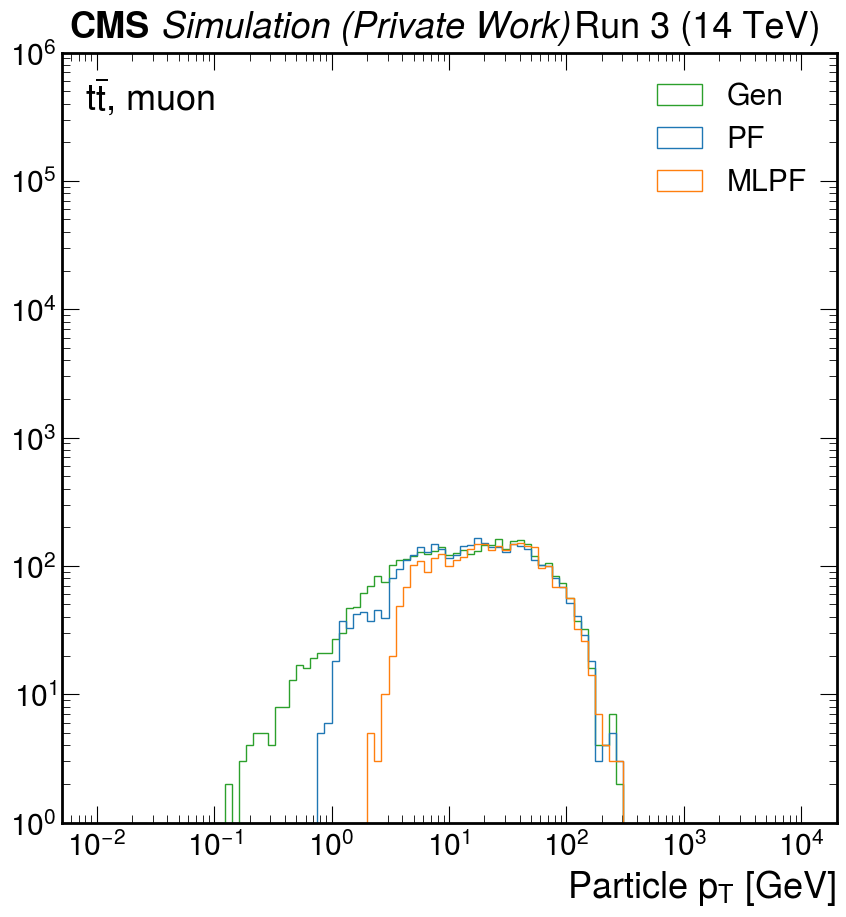

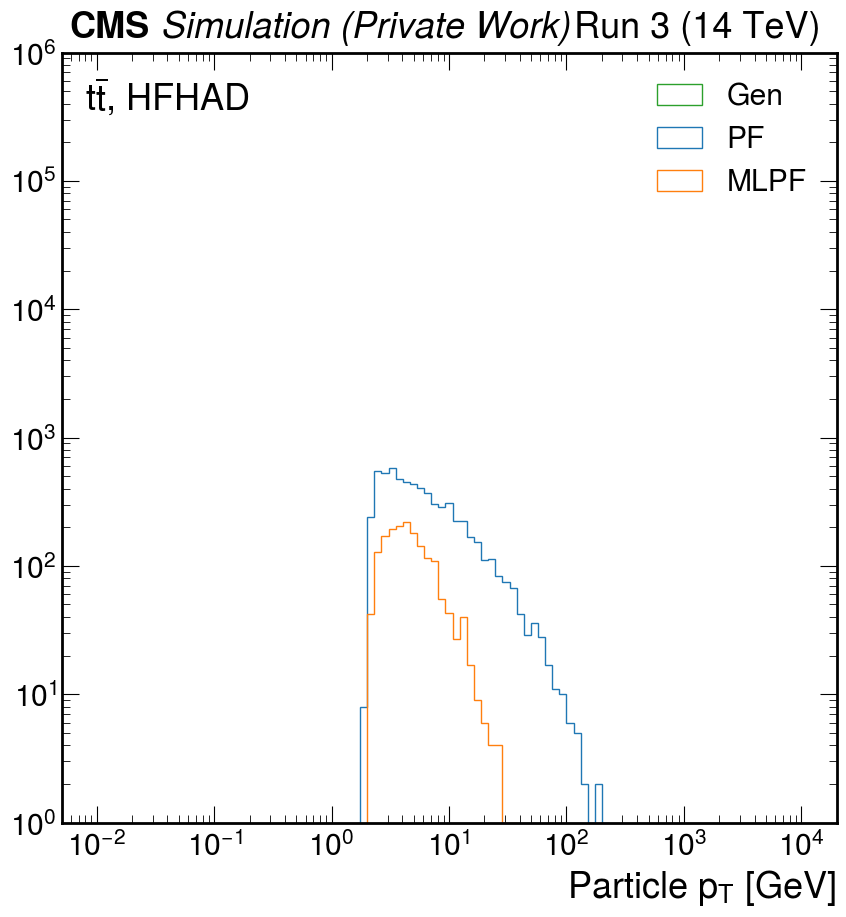

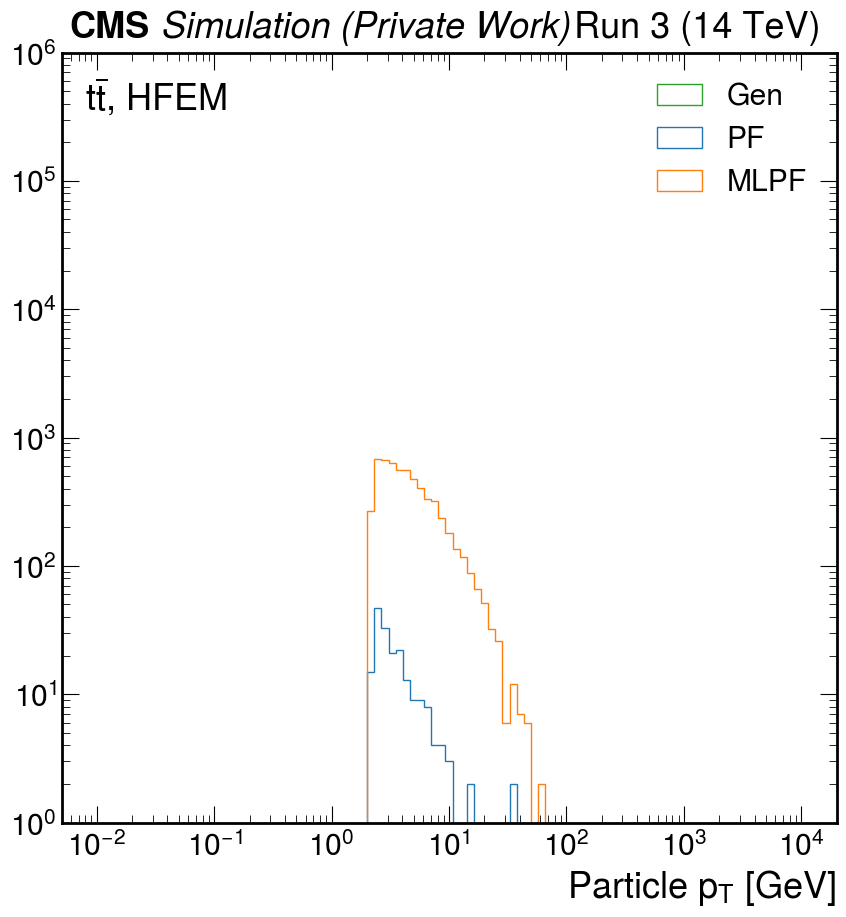

In [9]:
for pid, ptcl_name in [
    (211, "ch.had"),
    (130, "n.had"),
    (22, "photon"),
    (11, "electron"),
    (13, "muon"),
    (1, "HFHAD"),
    (2, "HFEM")
    ]:

    fig = plt.figure()
    ax = plt.axes()
    b=np.logspace(-2,4,100)
    plt.hist(ak.flatten(data_pf["GenCands_pt"][data_pf["GenCands_pid"]==pid]), bins=b, histtype="step", color="tab:green", label="Gen")
    plt.hist(ak.flatten(data_pf["PFCands_pt"][data_pf["PFCands_pid"]==pid]), bins=b, histtype="step", color="tab:blue", label="PF")
    plt.hist(ak.flatten(data_mlpf["PFCands_pt"][data_mlpf["PFCands_pid"]==pid]), bins=b, histtype="step", color="tab:orange", label="MLPF")
    plt.xscale("log")
    plt.yscale("log")
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar_nopu", ", "+ptcl_name)
    plt.ylim(1, 1e6)
    plt.xlabel("Particle $p_T$ [GeV]")
    plt.legend()

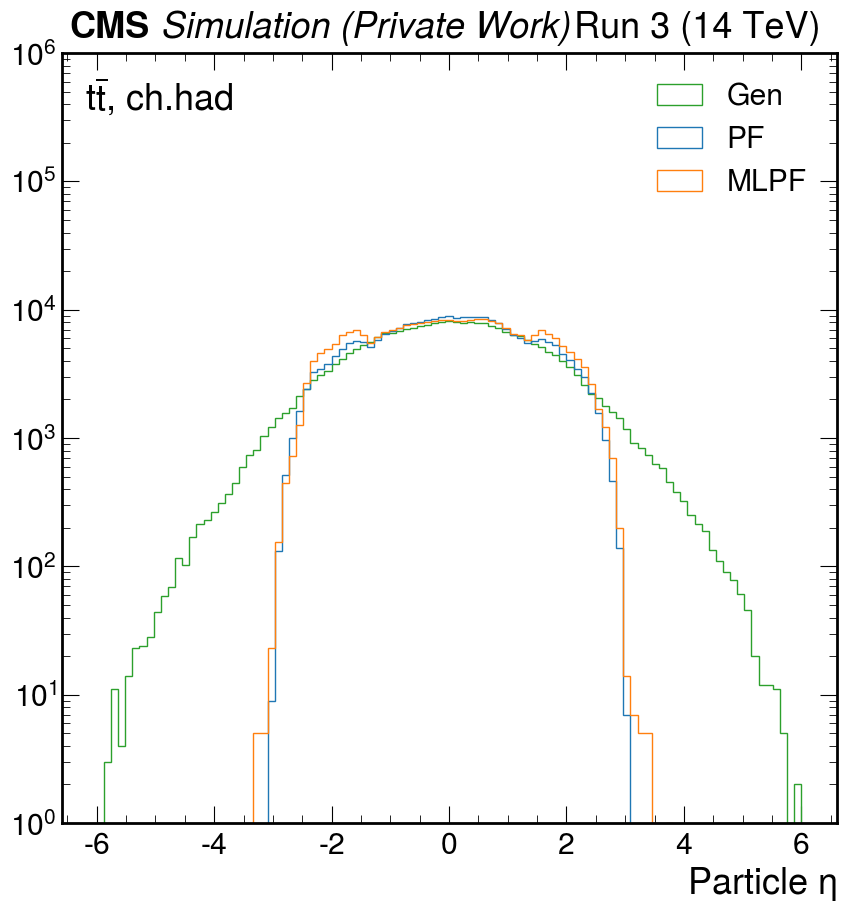

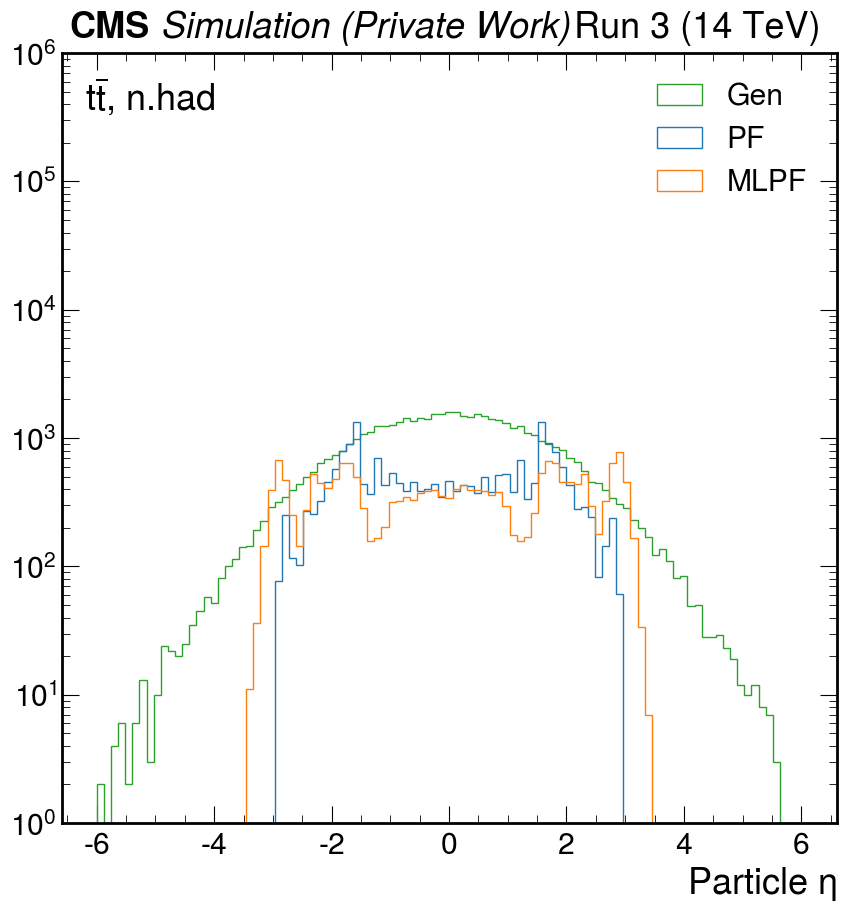

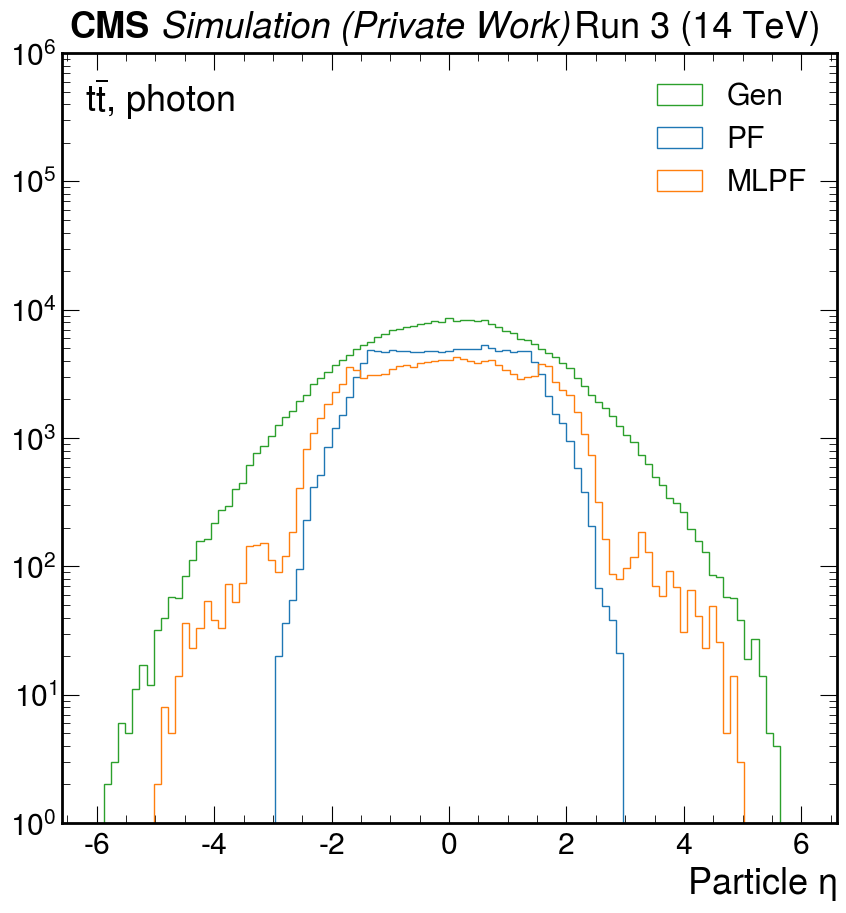

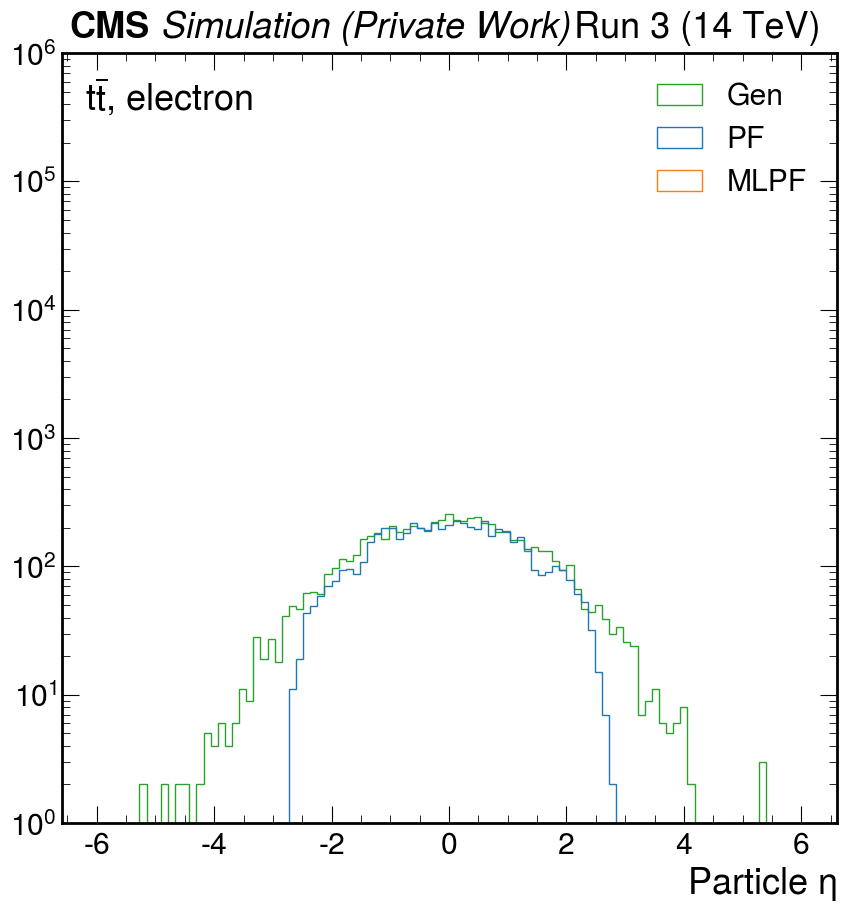

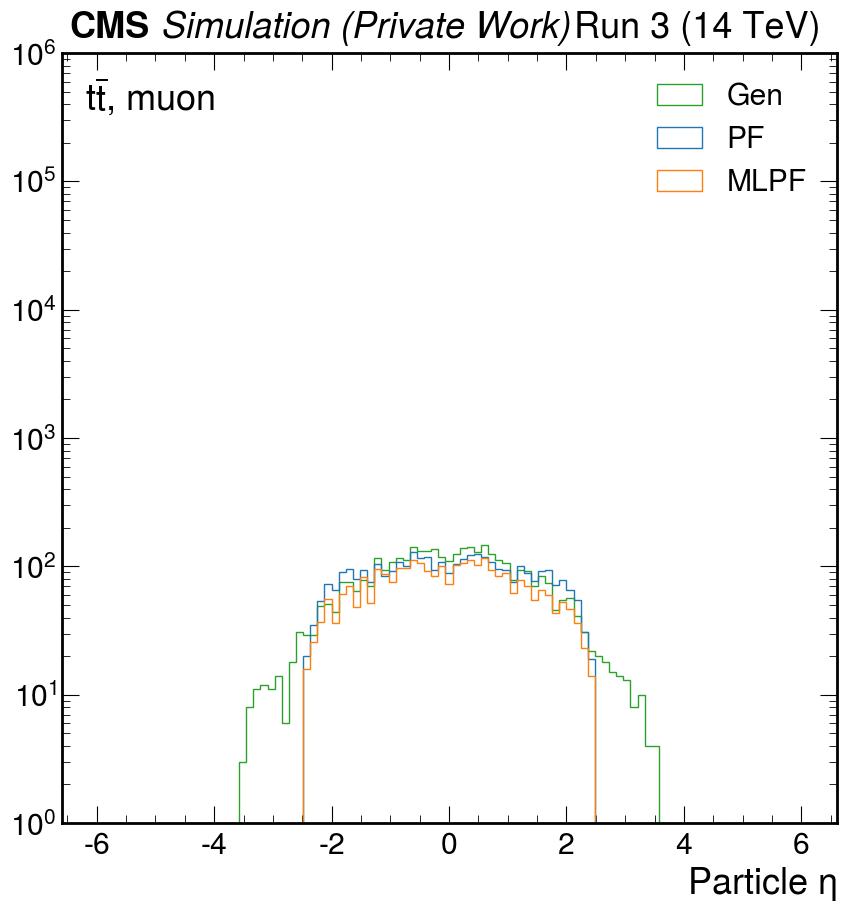

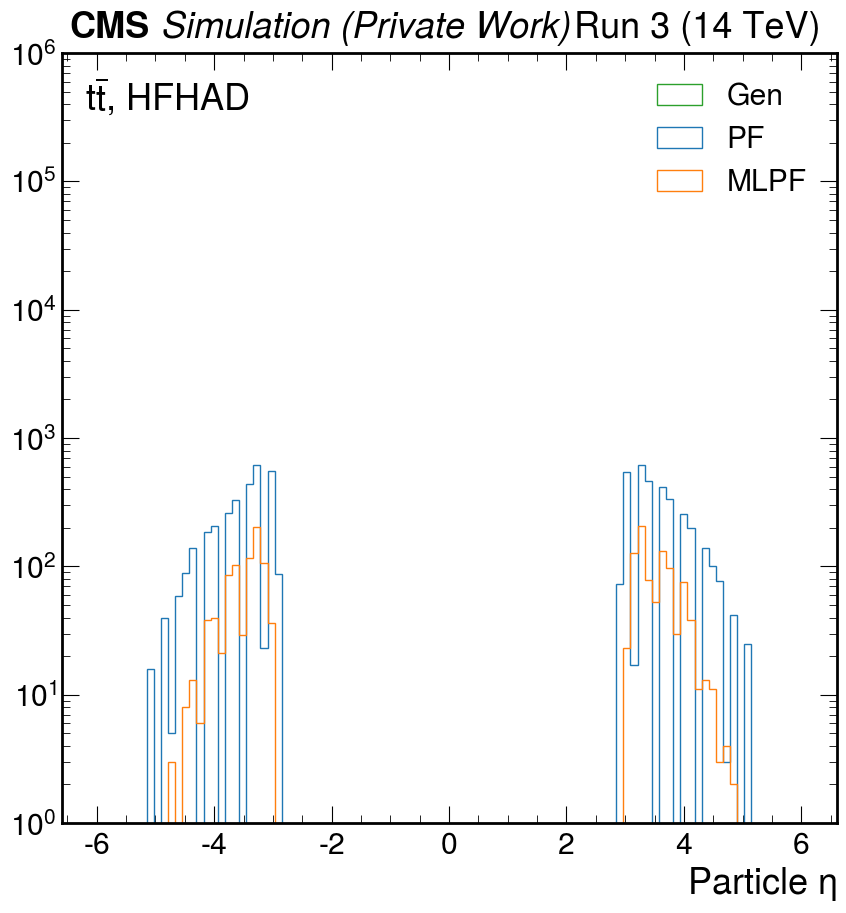

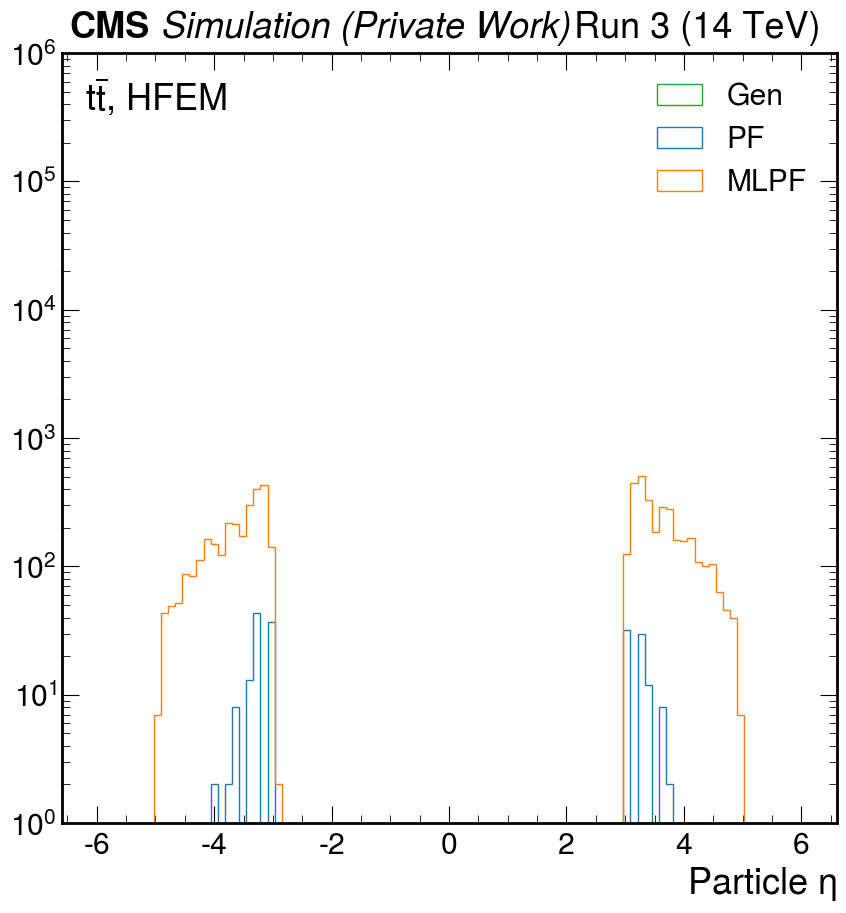

In [10]:
for pid, ptcl_name in [
    (211, "ch.had"),
    (130, "n.had"),
    (22, "photon"),
    (11, "electron"),
    (13, "muon"),
    (1, "HFHAD"),
    (2, "HFEM")
    ]:

    fig = plt.figure()
    ax = plt.axes()
    b=np.linspace(-6,6,100)
    plt.hist(ak.flatten(data_pf["GenCands_eta"][data_pf["GenCands_pid"]==pid]), bins=b, histtype="step", color="tab:green", label="Gen")
    plt.hist(ak.flatten(data_pf["PFCands_eta"][data_pf["PFCands_pid"]==pid]), bins=b, histtype="step", color="tab:blue", label="PF")
    plt.hist(ak.flatten(data_mlpf["PFCands_eta"][data_mlpf["PFCands_pid"]==pid]), bins=b, histtype="step", color="tab:orange", label="MLPF")
    plt.yscale("log")
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar_nopu", ", "+ptcl_name)
    plt.ylim(1, 1e6)
    plt.xlabel("Particle $\eta$")
    plt.legend()

In [11]:
uniq_pids = [1,2,11,13,22,130,211]
pid_colors = ["tab:pink", "tab:gray", "tab:blue", "tab:orange", "tab:cyan", "tab:green", "tab:red"]

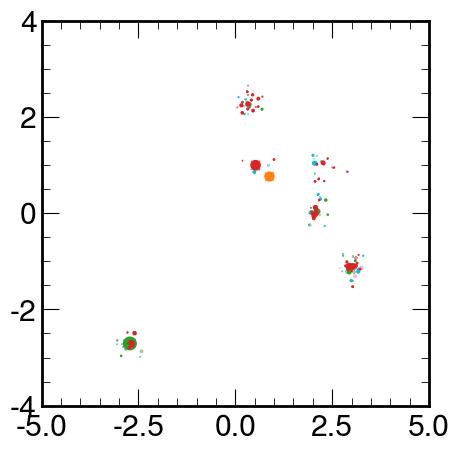

In [12]:
iev = 5
plt.figure(figsize=(5,5))
for pid, c in zip(uniq_pids, pid_colors):
    msk_pid1 = data_pf["GenCands_pid"]==pid
    msk_pid2 = data_pf["PFCands_pid"]==pid
    msk_pid3 = data_mlpf["PFCands_pid"]==pid
    plt.scatter(data_pf["GenCands_eta"][msk_pid1][iev], data_pf["GenCands_phi"][msk_pid1][iev], s=data_pf["GenCands_pt"][msk_pid1][iev], color=c)
    plt.scatter(data_pf["PFCands_eta"][msk_pid2][iev], data_pf["PFCands_phi"][msk_pid2][iev], s=data_pf["PFCands_pt"][msk_pid2][iev], marker="x", color=c, alpha=0.5)
    plt.scatter(data_mlpf["PFCands_eta"][msk_pid3][iev], data_mlpf["PFCands_phi"][msk_pid3][iev], s=data_mlpf["PFCands_pt"][msk_pid3][iev], marker="+", color=c, alpha=0.5)
    plt.xlim(-5,5)
    plt.ylim(-4,4)

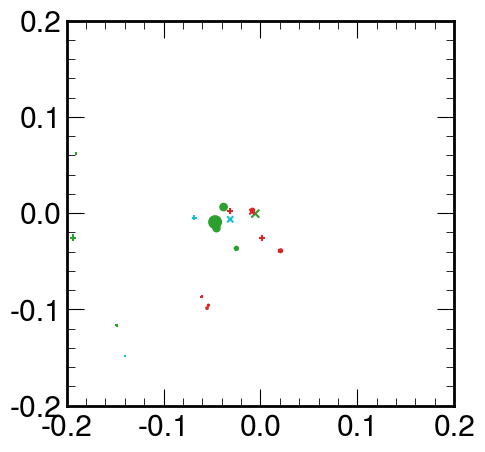

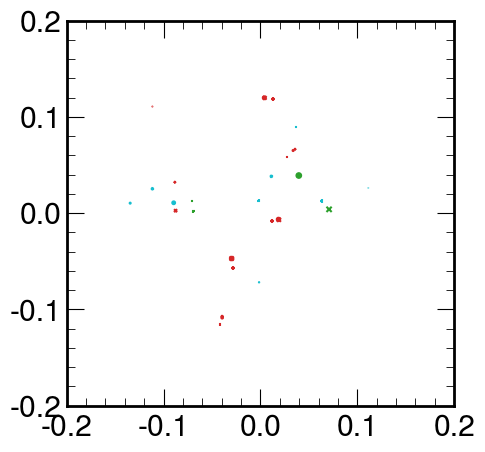

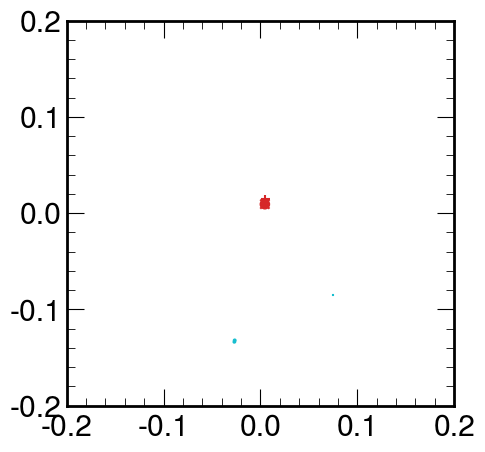

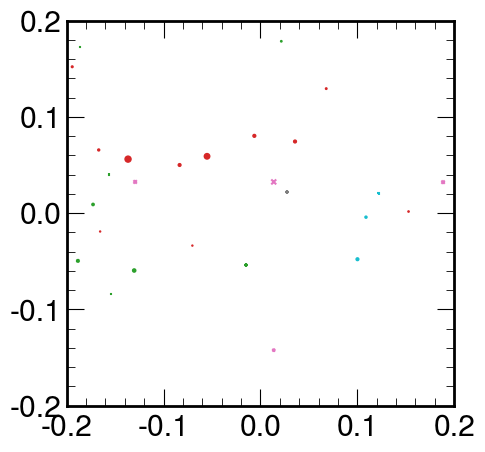

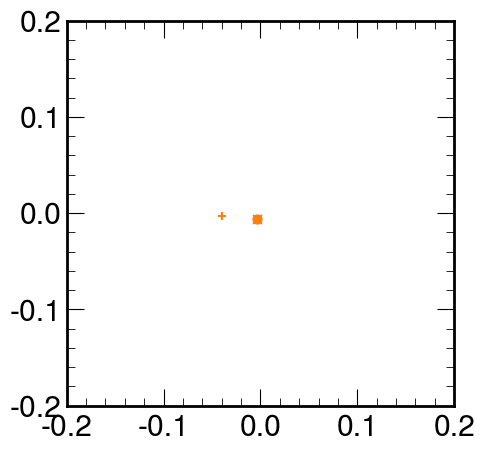

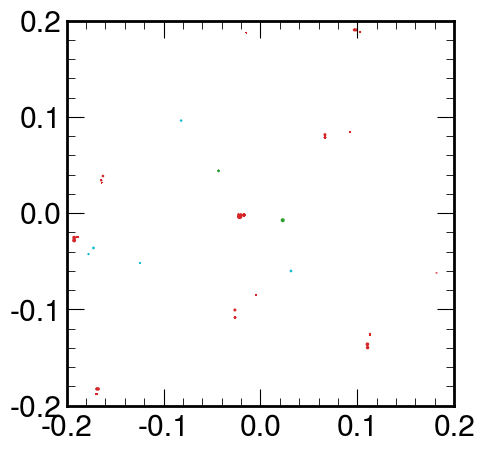

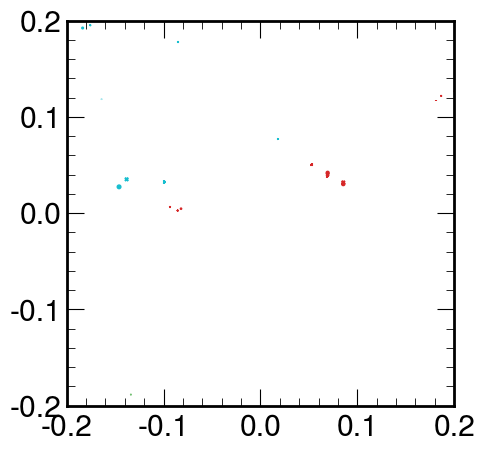

In [13]:
iev = 5
#visualize around genjets
for ijet in range(len(data_pf["Jet_pt"][iev])):
    if data_pf["Jet_pt"][iev][ijet]<5:
        continue
    plt.figure(figsize=(5,5))
    jet_eta = data_pf["Jet_eta"][iev][ijet]
    jet_phi = data_pf["Jet_phi"][iev][ijet]
    for pid, c in zip(uniq_pids, pid_colors):
        msk_pid1 = data_pf["GenCands_pid"]==pid
        msk_pid2 = data_pf["PFCands_pid"]==pid
        msk_pid3 = data_mlpf["PFCands_pid"]==pid
        plt.scatter(data_pf["GenCands_eta"][msk_pid1][iev]-jet_eta, deltaphi(ak.to_numpy(data_pf["GenCands_phi"][msk_pid1][iev]), jet_phi), s=data_pf["GenCands_pt"][msk_pid1][iev], color=c)
        plt.scatter(data_pf["PFCands_eta"][msk_pid2][iev]-jet_eta, deltaphi(ak.to_numpy(data_pf["PFCands_phi"][msk_pid2][iev]), jet_phi), s=data_pf["PFCands_pt"][msk_pid2][iev], marker="x", color=c)
        plt.scatter(data_mlpf["PFCands_eta"][msk_pid3][iev]-jet_eta, deltaphi(ak.to_numpy(data_mlpf["PFCands_phi"][msk_pid3][iev]), jet_phi), s=data_mlpf["PFCands_pt"][msk_pid3][iev], marker="+", color=c)
    plt.xlim(-0.2,0.2)
    plt.ylim(-0.2,0.2)

In [14]:
msk_pf_gen = data_pf["GenCands_pt"]>0.5
msk_pf_reco = data_pf["PFCands_pt"]>0.5

eta1 = data_pf["GenCands_eta"][msk_pf_gen]
phi1 = data_pf["GenCands_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, 0.15)

msk_mlpf_gen = data_mlpf["GenCands_pt"]>0.5
msk_mlpf_reco = data_mlpf["PFCands_pt"]>0.5

eta1 = data_mlpf["GenCands_eta"][msk_mlpf_gen]
phi1 = data_mlpf["GenCands_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, 0.15)

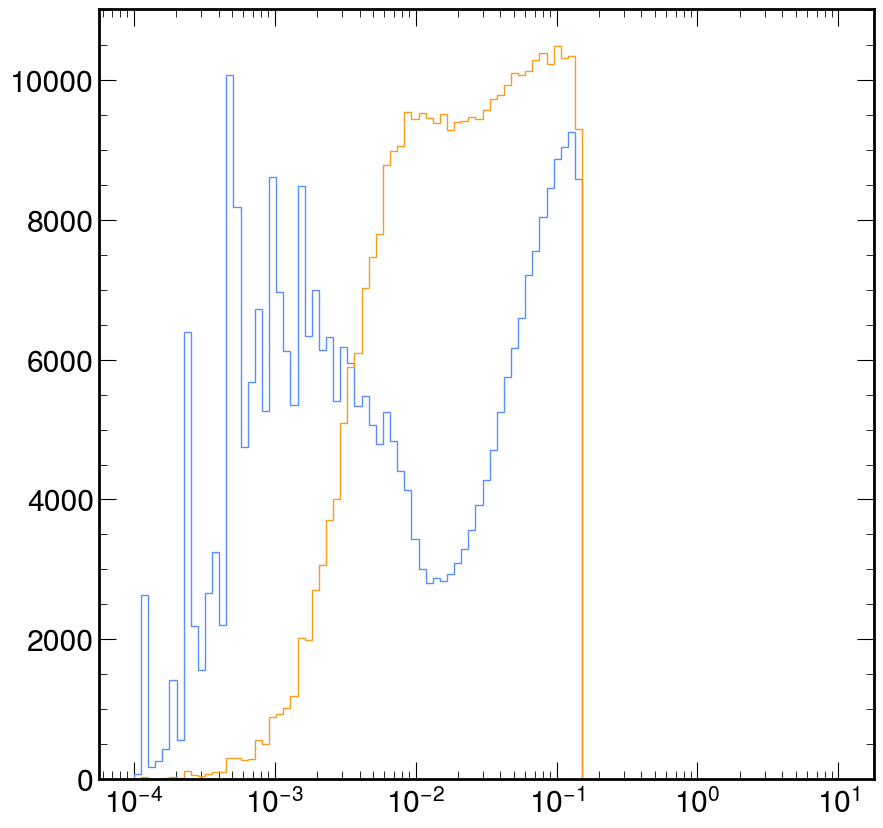

In [15]:
plt.hist(ak.flatten(pf_dr), bins=np.logspace(-4,1,100), histtype="step", label="PF")
plt.hist(ak.flatten(mlpf_dr), bins=np.logspace(-4,1,100), histtype="step", label="MLPF")
plt.xscale("log")

In [16]:
cm_pf = sklearn.metrics.confusion_matrix(
    ak.flatten(data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]),
    ak.flatten(data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]),
    labels=[211,130,22,11,13],
    normalize="true"
)

cm_mlpf = sklearn.metrics.confusion_matrix(
    ak.flatten(data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]),
    ak.flatten(data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]),
    labels=[211,130,22,11,13],
    normalize="true"
)

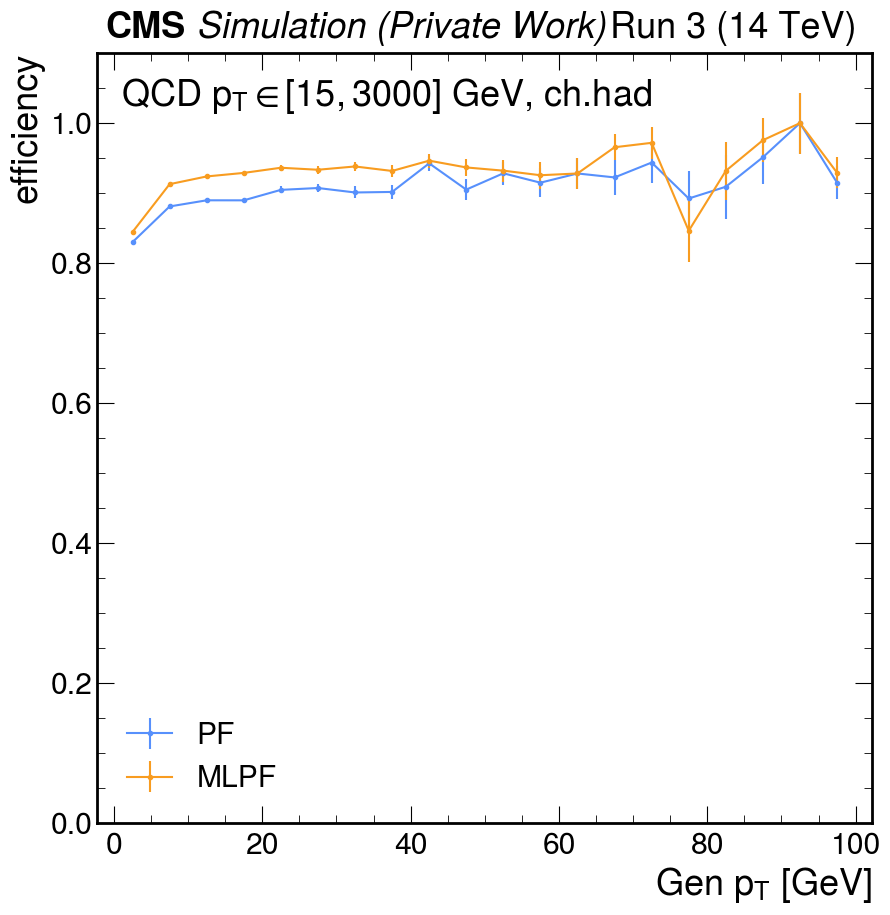

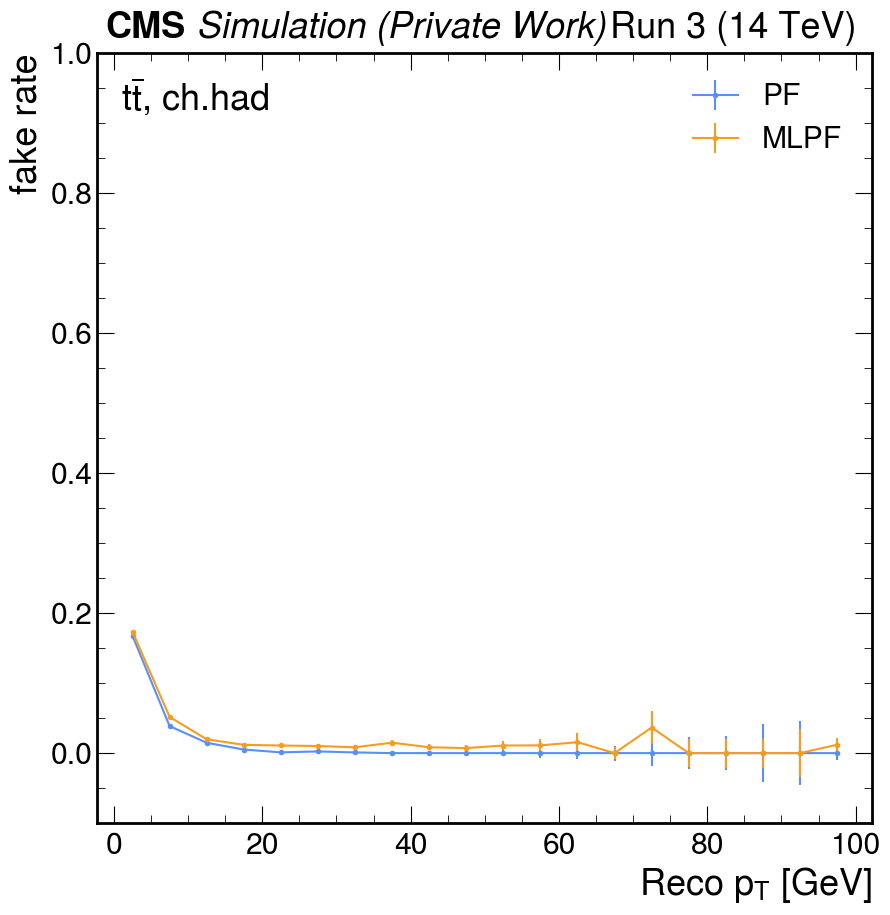

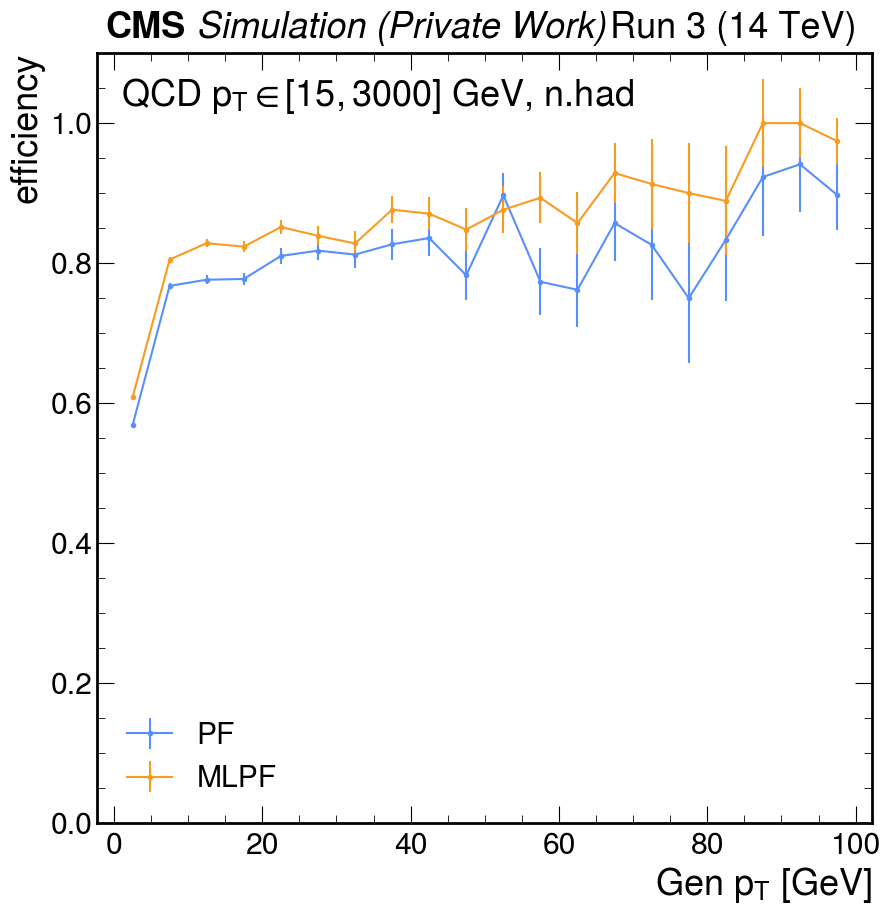

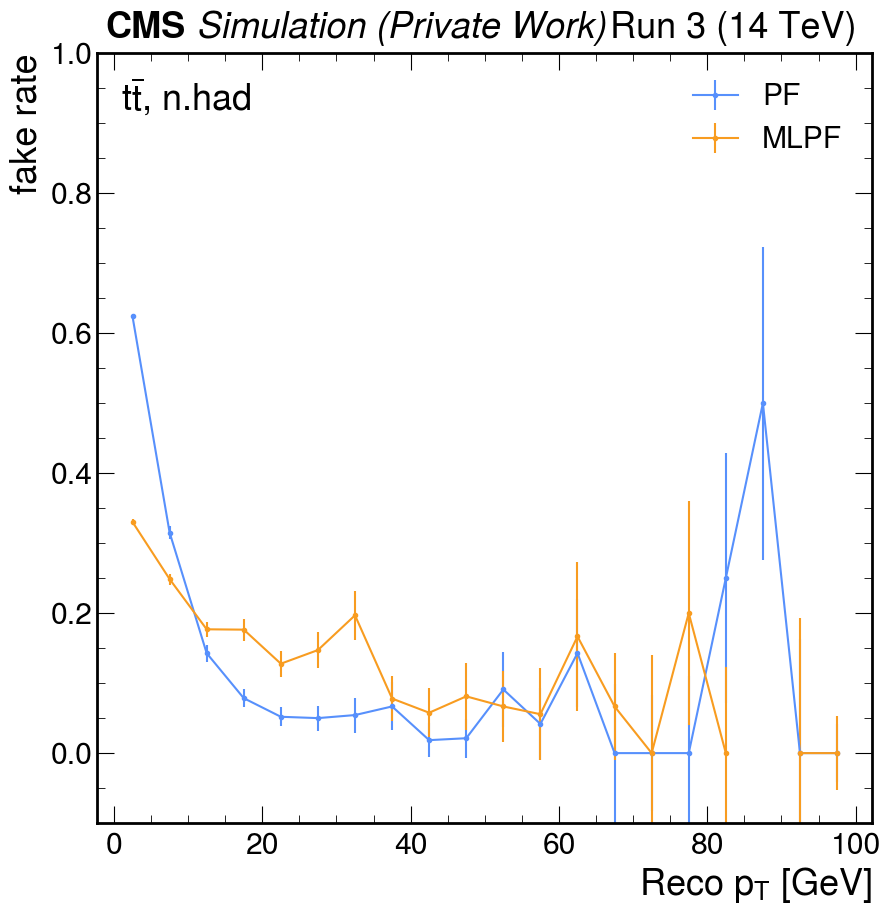

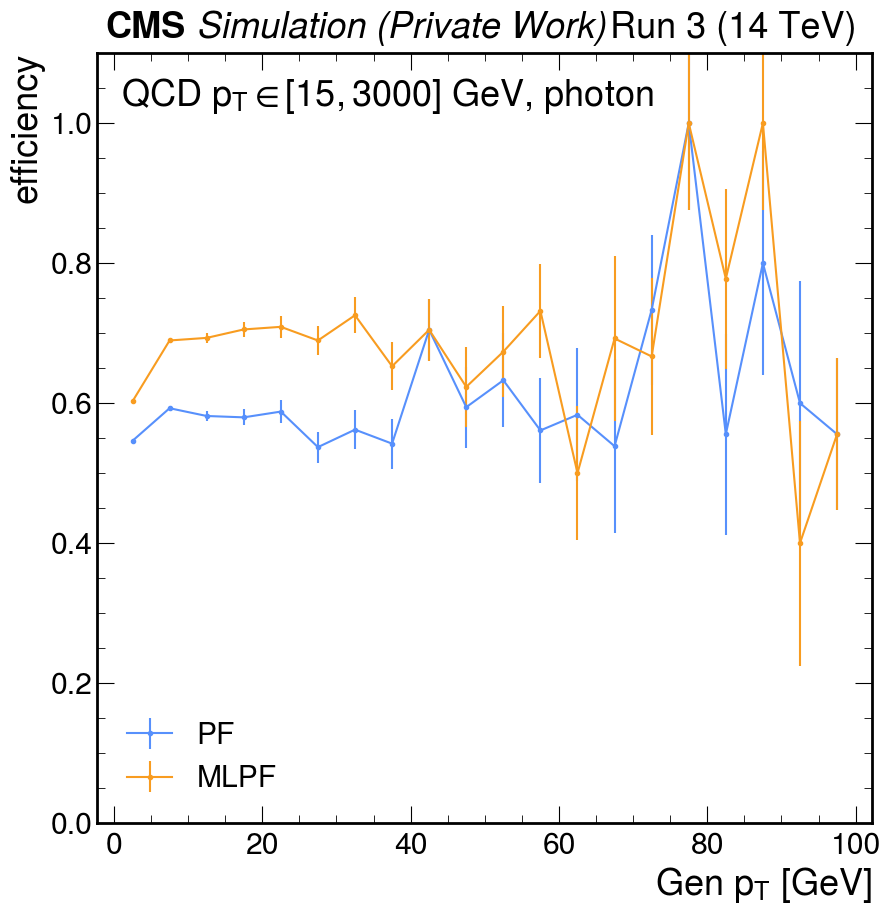

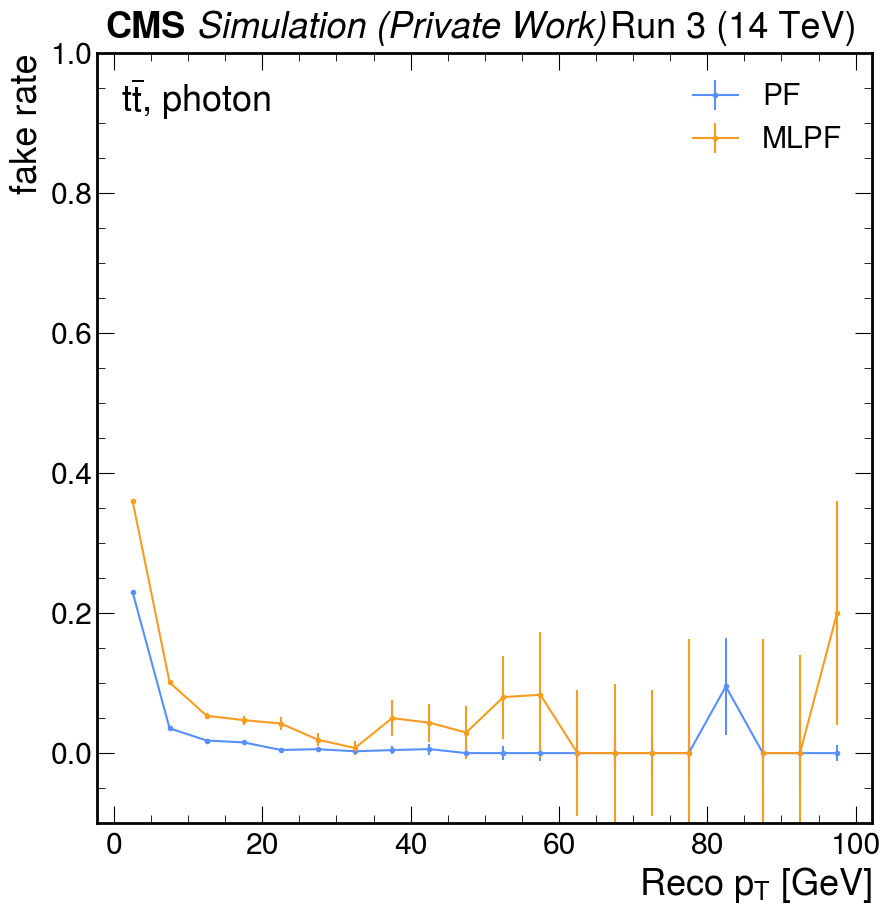

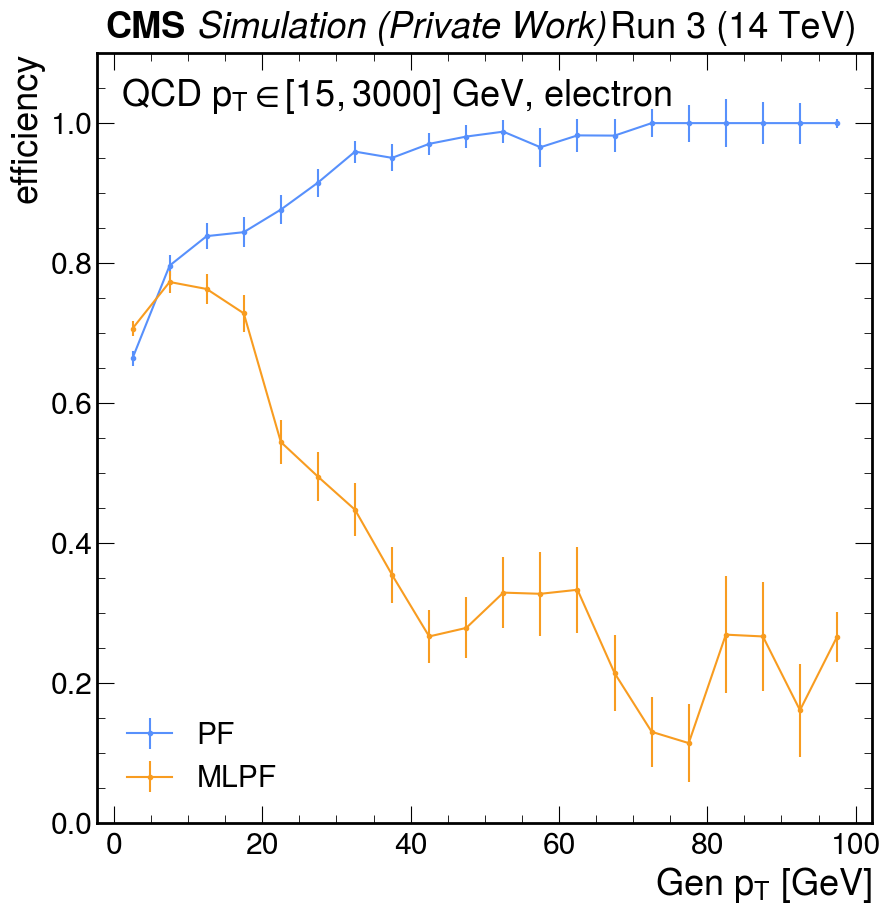

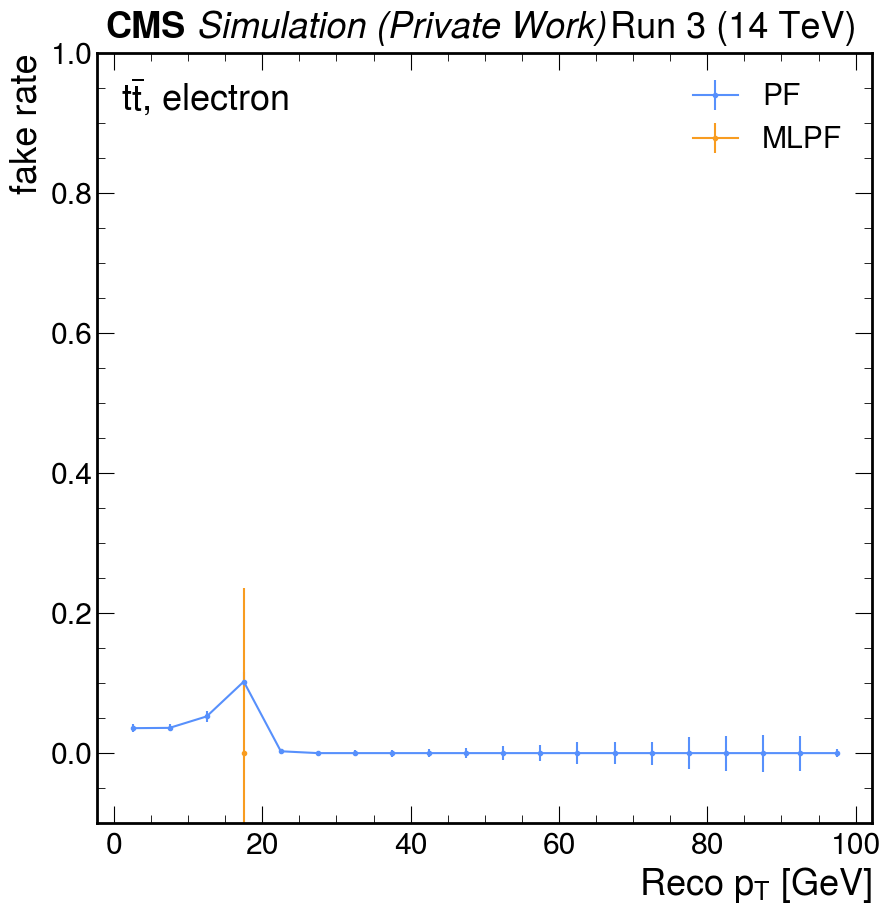

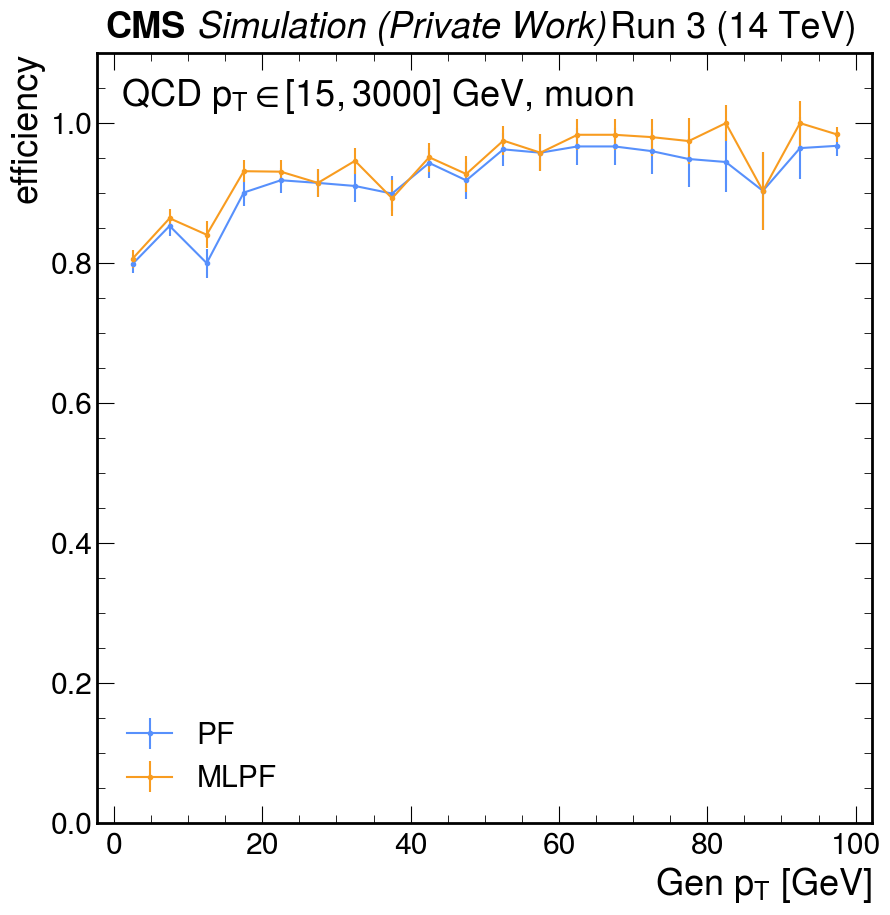

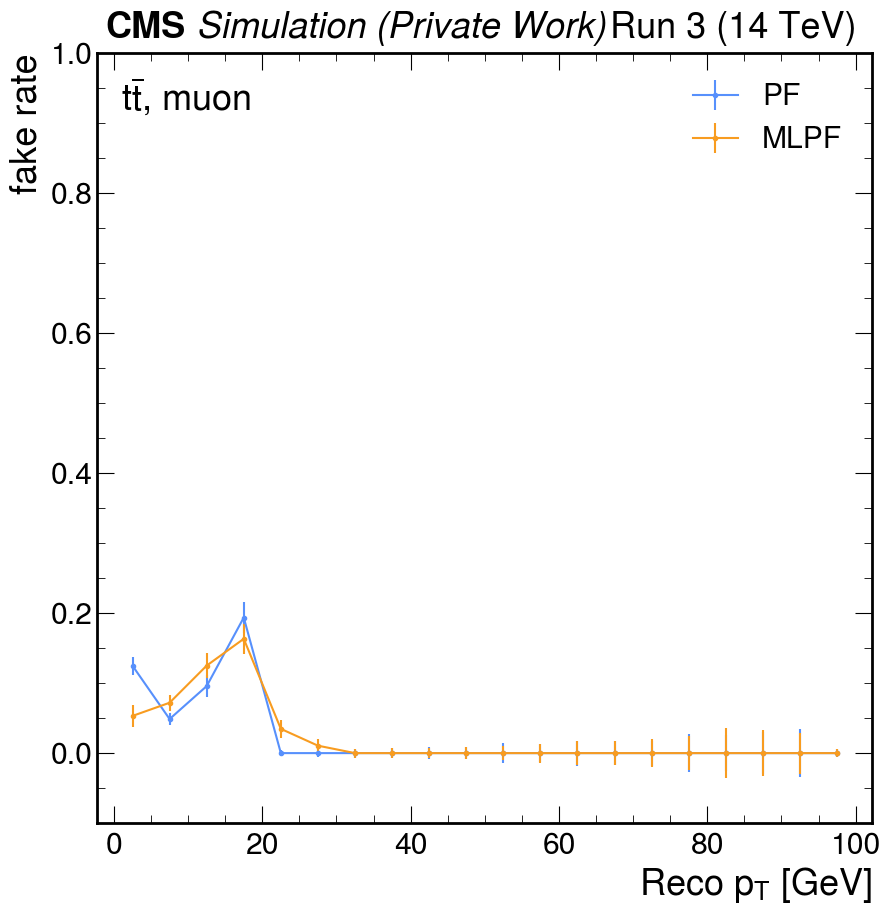

In [17]:
for pid, ptcl_name in [
    (211, "ch.had"),
    (130, "n.had"),
    (22, "photon"),
    (11, "electron"),
    (13, "muon")]:
    bins = np.linspace(0,100,21)

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), bins=bins)
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][pf_idx1][data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins)

    #pick recoparticles, and recoarticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins)
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins)

    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), bins=bins)
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1][data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins)
    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins)
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins)

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF",
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF",
    )
    plt.ylim(0, 1.1)
    plt.ylabel("efficiency")
    plt.xlabel("Gen $p_T$ [GeV]")
    plt.legend(loc="best")
    cms_label(ax)
    sample_label(ax, "cms_pf_qcd_nopu", ", "+ptcl_name)
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF",
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF",
    )
    plt.ylim(-0.1, 1.0)
    plt.ylabel("fake rate")
    plt.xlabel("Reco $p_T$ [GeV]")
    plt.legend(loc="best")
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar_nopu", ", "+ptcl_name)

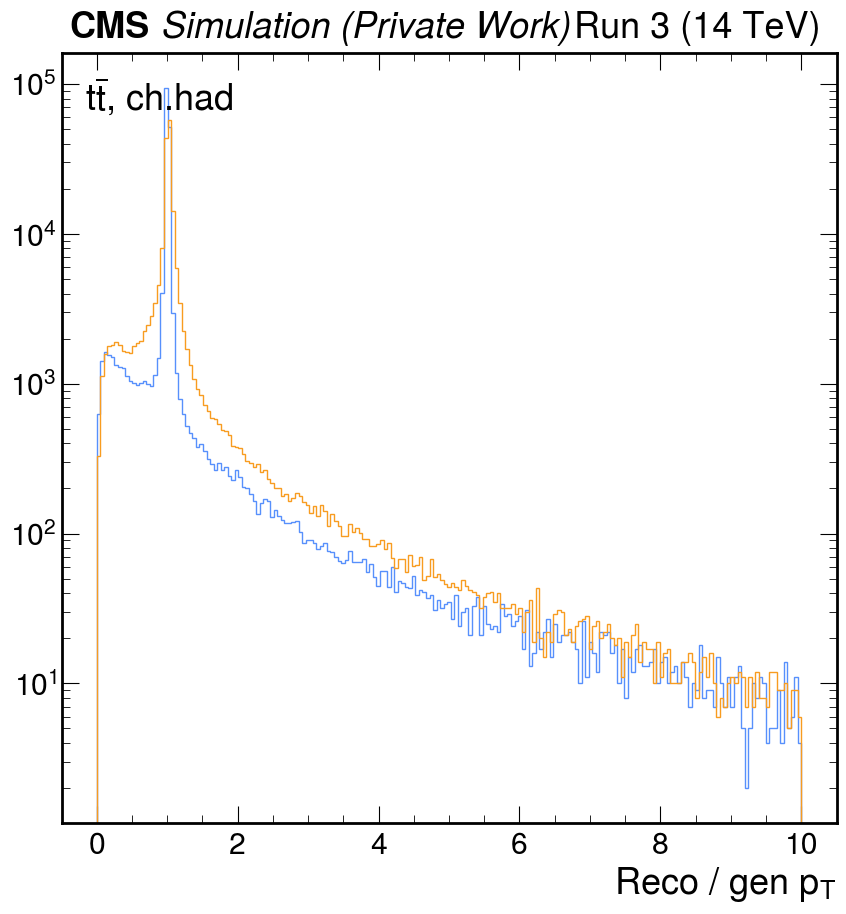

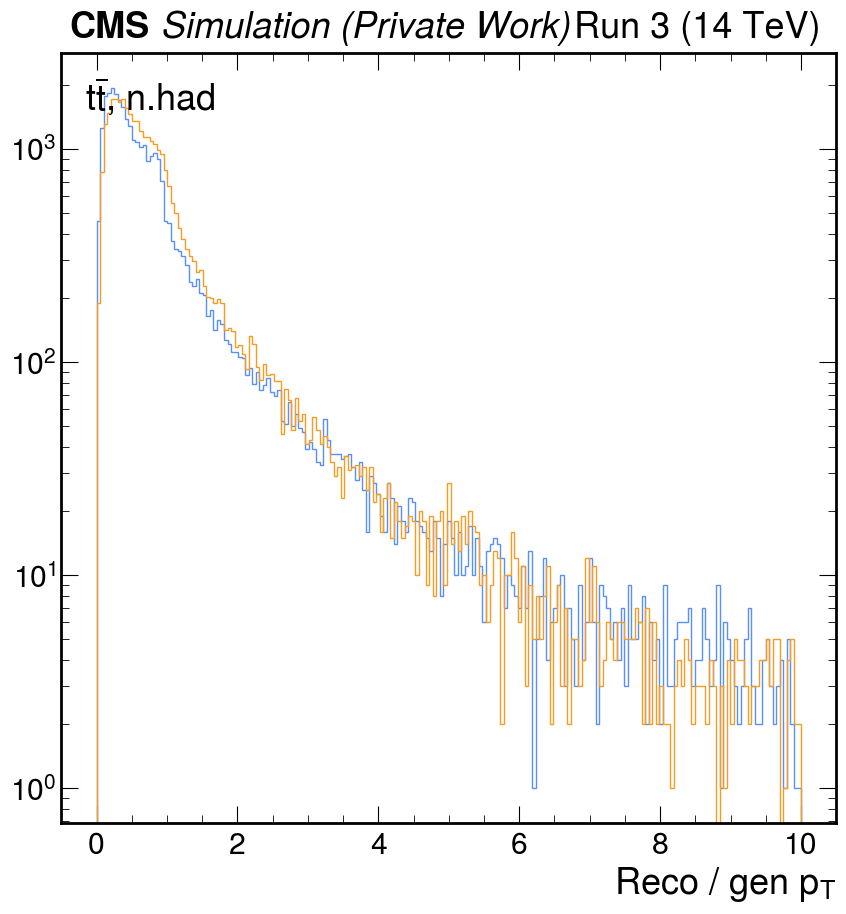

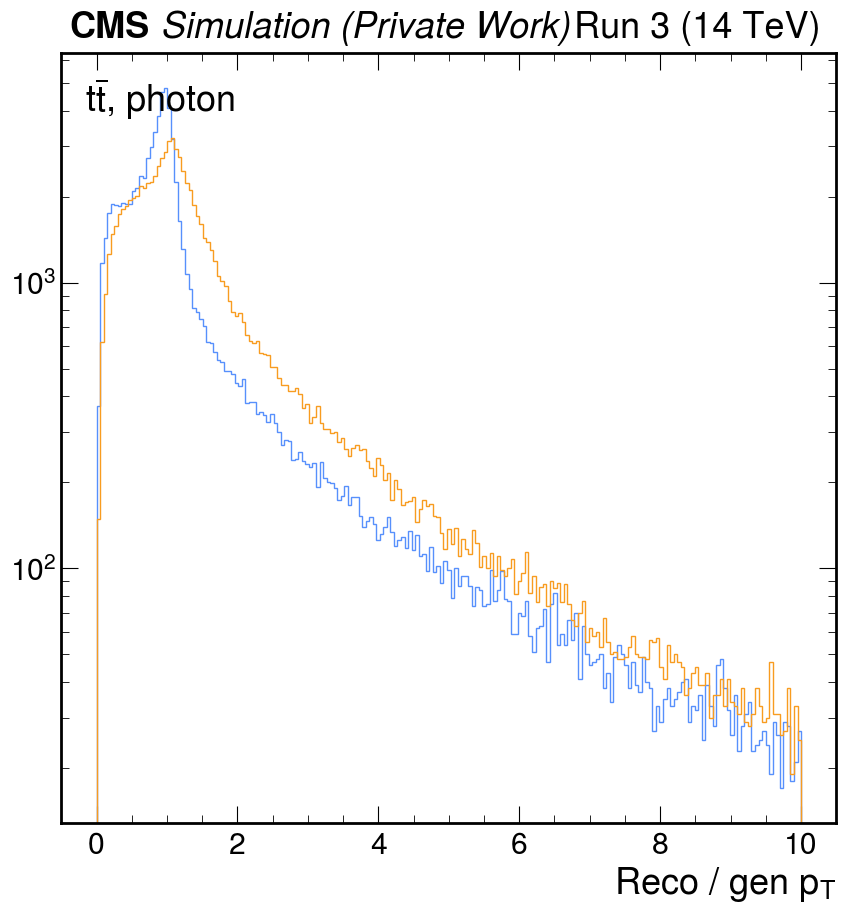

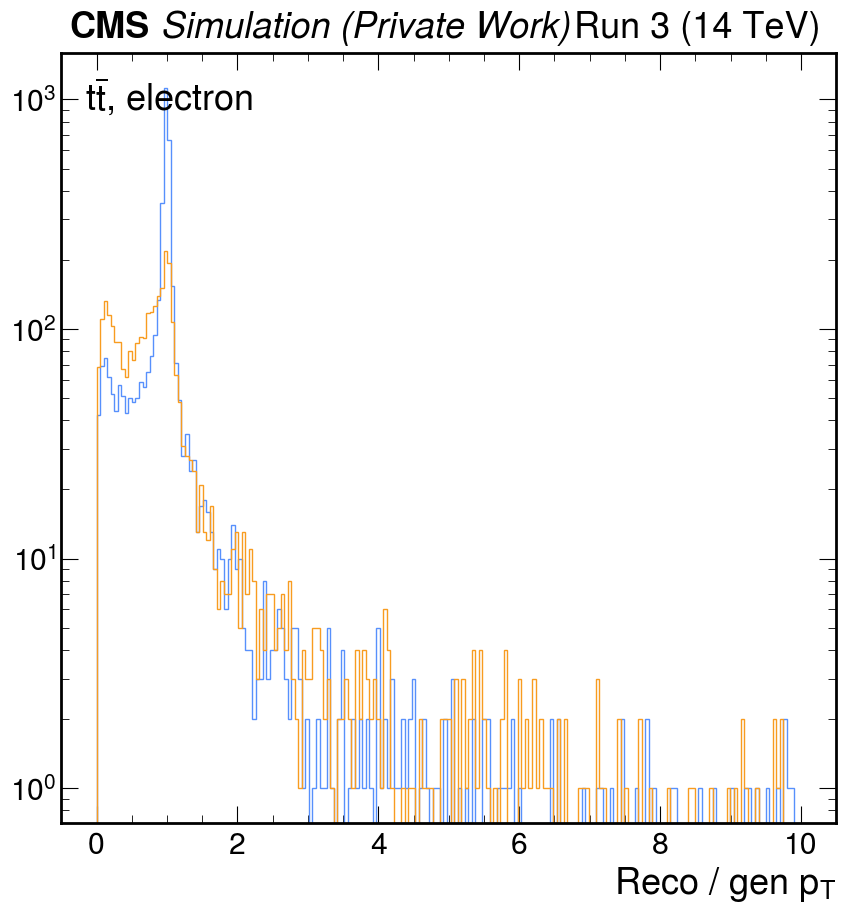

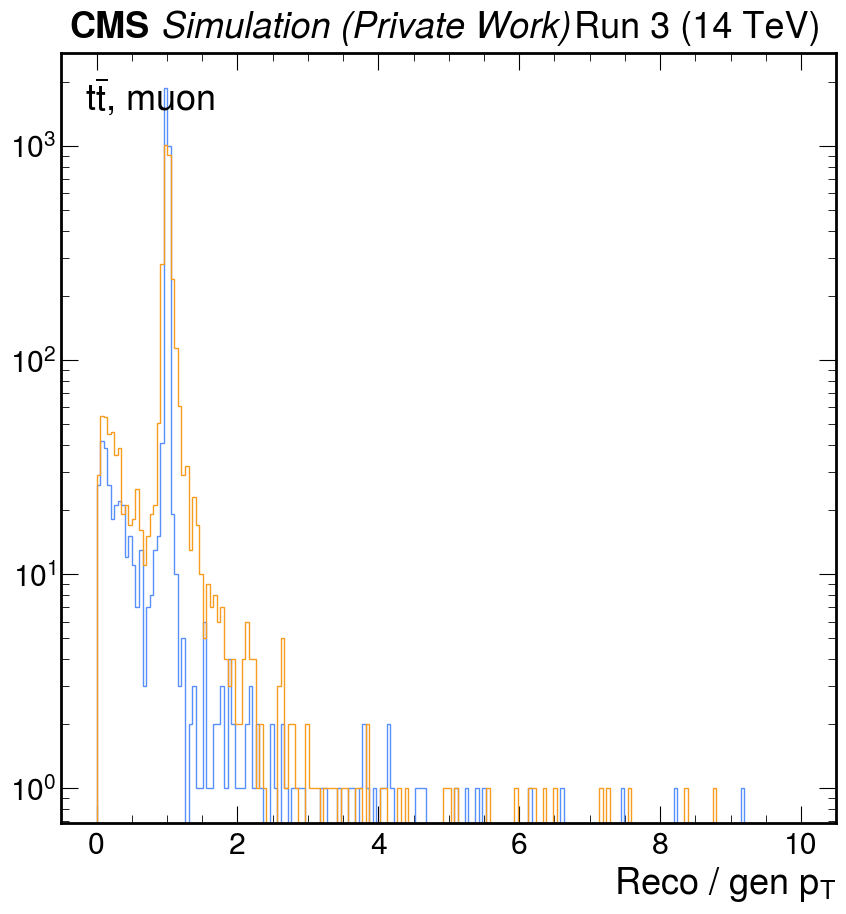

In [18]:
b = np.linspace(0,10,200)
for pid, ptcl_name in [
    (211, "ch.had"),
    (130, "n.had"),
    (22, "photon"),
    (11, "electron"),
    (13, "muon")]:
    
    fig = plt.figure()
    ax = plt.axes()
    plt.hist(ak.flatten((data_pf["PFCands_pt"][msk_pf_reco][pf_idx2]/data_pf["GenCands_pt"][msk_pf_gen][pf_idx1])[data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=b, histtype="step");
    plt.hist(ak.flatten((data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2]/data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1])[data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=b, histtype="step");
    plt.yscale("log")
    plt.xlabel("Reco / gen $p_T$")
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar_nopu", ", "+ptcl_name)